# Imports

In [20]:
from math import pi, sqrt, cos, sin, atan2, degrees, tan, exp
from random import random, gauss
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Setting up the Environment

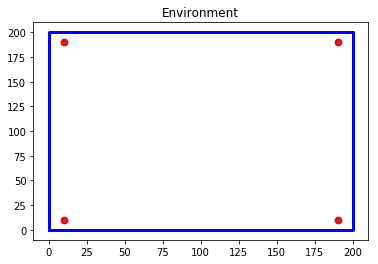

In [3]:
landmarks  = [[10, 10], [190, 190], [10, 190], [190, 10]]
world_size = 200
def drawEnv():
    x_landmark = [10, 190, 10, 190]
    y_landmark = [10, 190, 190, 10]
    # Draw point based on above x, y axis values.
    plt.scatter(x_landmark, y_landmark, s=8, edgecolors="red", linewidths=5)
    x_bounds = [0, 200, 200, 0, 0]
    # List to hold y values.
    y_bounds = [0, 0, 200, 200, 0]
    # Plot the environment bound
    plt.plot(x_bounds, y_bounds, linewidth=3, color='b')
    plt.title("Environment")
drawEnv()
plt.show()

# Initializing the Robot

In [4]:
MAX_STEERING_ANGLE = pi / 4 # r

def set_pos(new_x, new_y, new_orientation, new_steering):

    if new_x < 0 or new_x >= world_size:
        new_x = 0 if new_x < 0 else world_size
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_y < 0 or new_y >= world_size:
        new_y = 0 if new_y < 0 else world_size
        new_orientation = - pi
        new_orientation %= (2 * pi)
    if new_orientation < 0 or new_orientation >= 2 * pi:
        raise ValueError('Orientation must be in [0..2pi]')
    if new_steering < -MAX_STEERING_ANGLE or new_steering > MAX_STEERING_ANGLE:
        raise ValueError('Steering must be in [-pi/4..pi/4]')
    return float(new_x), float(new_y), float(new_orientation), float(new_steering)

BEARING_NOISE_VAR, STEERING_NOISE_VAR, DISTANCE_NOISE_VAR = (0.1, 0.1, 5)

ROBOT_LENGTH = 10

robot = {
            "front_x": random() * world_size//2,
            "front_y": random() * world_size//2,
            "orientation": random() * 2 * pi,
            "steering": 0#-MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

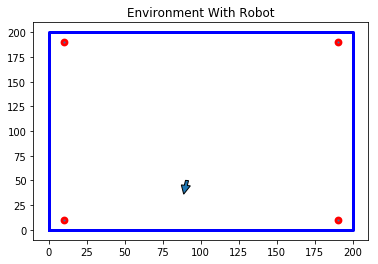

In [5]:
def drawEnvWithBot():
    drawEnv()
    plt.title("Environment With Robot")
    plt.arrow(robot['front_x'], robot['front_y'], cos(robot['orientation']) * 5, sin(robot['orientation']) * 5, width=2)
drawEnvWithBot()
plt.show()

# Sense Function

In [6]:
def getAngle(fromX,fromY,toX,toY):
    deltaX = fromX - toX
    deltaY = fromY - toY
    return atan2(deltaY, deltaX)

x2 = []
y2 = []

def sense(rob):
    Z = []
    for landmark in landmarks:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z))
        y2.append(rob['front_y'] + dist * -sin(z))
        Z.append(z)

    return Z

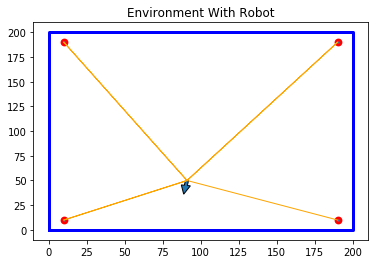

In [7]:
s = sense(robot)

def drawEnvWithSensorReadings():
    line_x = []
    for x in x2:
        line_x.append(robot['front_x'])
        line_x.append(x)

    line_y = []
    for y in y2:
        line_y.append(robot['front_y'])
        line_y.append(y)

    plt.plot(line_x, line_y, linewidth=1, color='orange')
    drawEnvWithBot()
drawEnvWithSensorReadings()
plt.show()

In [8]:
def sense(rob):
    Z = []
    for landmark in landmarks:
        z = getAngle(rob['front_x'], rob['front_y'], landmark[0], landmark[1])
        z += gauss(0, 0.1)
        dist = sqrt(((rob['front_x'] - landmark[0])**2) + ((rob['front_y'] - landmark[1])**2))
        x2.append(rob['front_x'] + dist * -cos(z))
        y2.append(rob['front_y'] + dist * -sin(z))
        Z.append(z)

    return Z

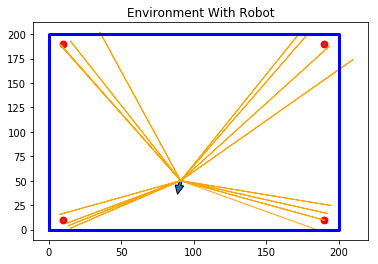

In [9]:
x2 = []
y2 = []

for _ in range(4):
    s = sense(robot)
drawEnvWithSensorReadings()
plt.show()


# Move Function

In [10]:
def move(rob, steer_angle, distance):
    if steer_angle < -MAX_STEERING_ANGLE or steer_angle > MAX_STEERING_ANGLE:
        raise ValueError('Robot can only steer in [-pi/4..pi/4]')
    if distance < 0:
        raise ValueError('Robot can only move forward')

    # get steering angle
    steering = steer_angle + gauss(0, STEERING_NOISE_VAR) #rob['steering'] +
    steering = MAX_STEERING_ANGLE if steering > MAX_STEERING_ANGLE else steering
    steering = -MAX_STEERING_ANGLE if steering < MAX_STEERING_ANGLE else steering
    #steering %= MAX_STEERING_ANGLE

    # get distance
    dist = distance + gauss(0.0, DISTANCE_NOISE_VAR)

    # get turn angle
    turn = (dist/ROBOT_LENGTH) * tan(steering)

    if turn > 0.001 or turn < -0.001:
        # Bycicle Model
        r = tan((pi/2) - steering) * ROBOT_LENGTH

        Cx = rob['front_x'] - (r * sin(rob['orientation']))
        Cy = rob['front_y'] + (r * cos(rob['orientation']))

        x = Cx + (r * sin(rob['orientation'] + turn))
        y = Cy - (r * cos(rob['orientation'] + turn))

        orientation = (rob['orientation'] + turn)
        orientation %=( 2 * pi)

    else:
        # Linear Model
        x = rob['front_x'] + (cos(rob['orientation']) * dist)
        y = rob['front_y'] + (sin(rob['orientation']) * dist)
        x %= world_size
        y %= world_size
        orientation = (rob['orientation'] + steering)
        orientation %= (2 * pi)

        rob['front_x'], rob['front_y'], rob['orientation'], rob['steering'] = set_pos(x, y, orientation, steering)
    return rob

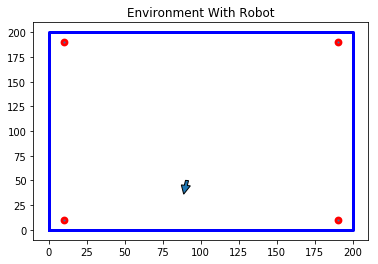

In [11]:
robot = move(robot, 0, 10)

drawEnvWithBot()
plt.show()

# Particle Filter

In [12]:
def Gaussian(mu, sigma, x):
    # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
    return exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / sqrt(2.0 * pi * (sigma ** 2))

In [13]:
def measurement_prob(rob, measurement):
    # calculates how likely a measurement should be
    prob = 1.0

    for i in range(len(landmarks)):
        dist = sqrt((rob['front_x'] - landmarks[i][0]) ** 2 + (rob['front_y'] - landmarks[i][1]) ** 2)
        prob *= Gaussian(dist, BEARING_NOISE_VAR, measurement[i])
    return prob

In [14]:
# def __repr__(self):
#     return '[x=%.6s y=%.6s orient=%.6s]' % (str(self.x), str(self.y), str(self.orientation))

In [15]:
def evaluate(rob, particles):
    sum = 0.0
    for i in range(len(particles)): # calculate mean error
        dx = (p[i]['front_x'] - rob['front_x'] + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i]['front_y'] - rob['front_y'] + (world_size/2.0)) % world_size - (world_size/2.0)
        err = sqrt(dx * dx + dy * dy)
        sum += err
    return sum / float(len(p))

In [25]:
# --------

N = 1000
T = 10

robot = {
            "front_x": random() * world_size//2,
            "front_y": random() * world_size//2,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }

p = []
for i in range(N):
    r = {
            "front_x": random() * world_size//2,
            "front_y": random() * world_size//2,
            "orientation": random() * 2 * pi,
            "steering": -MAX_STEERING_ANGLE + (MAX_STEERING_ANGLE*2)*random()
        }
    p.append(r)

print( 'Mean error at start ', evaluate(robot, p))
# show particle's initial locations
for i, _p in enumerate(p):
    print(_p['front_x'], _p['front_y'], _p['orientation'], _p['steering'])
    if i == 5:
        break

Mean error at start  50.26446367712418
91.0 79.0 0.43825539855531825 0.24897346482410776
42.0 87.0 3.670780721365237 -0.22623912405123503
18.0 95.0 5.573176869963517 -0.7412216119240949
82.0 98.0 6.036254518938238 0.1675599116816756
1.0 79.0 1.3230831324388144 -0.23009443581376576
79.0 63.0 0.8278451418272055 -0.2848017173982894


In [28]:
for t in range(T):
#    print p
    robot = move(robot, 0.1, 5.0)

    Z = sense(robot)

    p2 = []

    for i in range(N):
        p2.append(move(p[i], 0.1, 5.0))
    p = p2

    w = []
    for i in range(N):
        w.append(measurement_prob(p[i], Z))
    p3 = []
# this is importance sampling code

    index = int(random() * N)
    beta = 0.0
    mw = max(w)
    for i in range(N):
        beta += random() * 2.0 * mw
        while beta > w[index]:
            beta -= w[index]
            index = (index + 1) % N
        p3.append(p[index])
    p = p3

    print('Mean error',evaluate(robot, p))

Mean error 48.30113870293292
Mean error 48.30113870293292
Mean error 48.30802953816355
Mean error 48.304604863269624
Mean error 48.304604863269624
Mean error 48.304604863269624
Mean error 48.304604863269624
Mean error 48.30448319532301
Mean error 48.310824171605574
Mean error 48.30488336729456


In [35]:
print(' ')
if evaluate(robot, p) > 0.0:
    for i in range(N//100):
        print ('Final particle {}: {} {} {} {}'.format(i*100, p[i*100]['front_x'], p[i*100]['front_y'],
                                                       p[i*100]['orientation'], p[i*100]['steering']))
    print(' ')
    print('Actual Robot Location {} {} {} {}'.format(robot['front_x'], robot['front_y'],
                                                       robot['orientation'], robot['steering']))

 
Final particle 0: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 100: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 200: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 300: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 400: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 500: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 600: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 700: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 800: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
Final particle 900: 72.99790698738462 39.01230909814126 1.9676691373996755 -0.7853981633974483
 
Actual Robot Location 30.0 17.0 3.16419942627375